In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np

In [3]:
image = np.random.randn(30, 32, 32)
filters = np.random.randn(32,image.shape[0], 3,3) * 0.1

In [4]:
patch = image[:, :3, :3]
patch.shape

(30, 3, 3)

In [5]:
filters[0].shape

(30, 3, 3)

In [6]:
conv  = filters[0] * patch 
conv.shape

(30, 3, 3)

In [7]:
np.sum(conv)

0.04783374082596417

In [8]:
np.linalg.norm([[1,2],[2,3]])

4.242640687119285

In [9]:
np.sqrt(np.sum(np.array([[1,2],[2,3]])**2))

4.242640687119285

# Steps

- Train loop
    - Forward
        - Conv
        - Relu
        - Conv
        - Relu
        - Dense
        - Softmax
        - Cross entropy
    
    Backprop the gradients for all the layers

    Test the code for MNIST

In [10]:
import mnist

In [28]:
mnist.init()

Download complete.
Save complete.


In [11]:
x_train, y_train, x_test, y_test = mnist.load()

In [19]:
x_train.shape

(60000, 784)

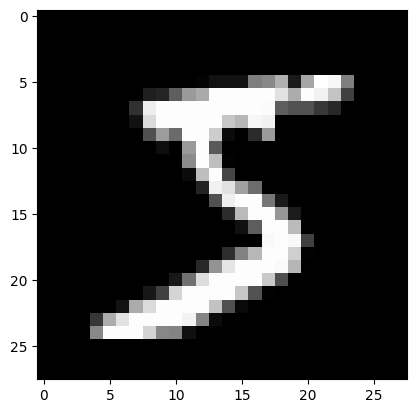

In [13]:
import matplotlib.pyplot as plt

img = x_train[0,:].reshape(28,28) # First image in the training set.
plt.imshow(img,cmap='gray')
plt.show() # Show the image

In [20]:

from layer import Layer

In [21]:
in_n, out_n = 62,32
limit = np.sqrt(2 / float(in_n + out_n))
weights = np.random.normal(0.0, limit, size = (in_n, out_n))

In [22]:
weights.shape

(62, 32)

### Weight init using Xavier/Gloror

In [27]:
import activations

In [34]:
class DenseLayer(Layer):
    def __init__(self, layer_name, input_nodes, output_nodes):
        super().__init__(layer_name)
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes

        '''
        Gloro/Xavier initialization for weights for faster convergence
        https://pyimagesearch.com/2021/05/06/understanding-weight-initialization-for-neural-networks/
        '''
        limit = np.sqrt(2 / float(input_nodes + output_nodes))
        self.weights = np.random.normal(0.0, limit, size = (input_nodes, output_nodes))

        ''' 
        No initialization is required for bias,
        https://cs231n.github.io/neural-networks-2/#:~:text=Initializing%20the%20biases
        '''
        self.bias = np.zeros(output_nodes)

        #we need to cache the input and output from this layer for the purpose of backprop
        self.cached_input = None
        self.cached_output = None

    # overriden
    def forward(self, input_activations):
        '''

        @param input_activations - Output of previous layer
        @return softmax of logits

        Dense layer forward prop
        1. Flatten the input
        2. Dot product with weights and add the bias
        3. Cache the input and logits for backpop
        4. Apply softmax on logits and return it
        '''

        layer_input = input_activations.flatten()
        layer_logits = np.dot(layer_input, self.weights) + self.bias

        self.cached_input = layer_input
        self.cached_output = activations.softmax(layer_logits)

        return self.cached_output


    #overriden
    def backward(self, global_gradient, true_labels, current_lr):
        '''
        @param global_gradient, will be zeros for dense layer, so don't use it
        @param current_lr 


        @returns The gradient of Loss w.r.t to the input to this layer
        i.e the input_activations recieved during forward pass.

        Dense layer backward prop
        1. Calculate the gradients w.r.t to the weights
        2. Calculate the gradients w.r.t to the received activations
        and return it for usage in other previous layers.

        '''
        output_grad  = self.cached_output
        output_grad[range(true_labels.shape[1]), true_labels] -= 1

        current_weight = self.weights
        self.weights -= current_lr * (np.dot(output_grad, self.cached_input))
        self.bias -= current_lr * output_grad

        gradients_to_next_layer = np.dot(current_weight, output_grad)
        return gradients_to_next_layer


In [35]:
dense_1 = DenseLayer("Dense_1", 784, 10)

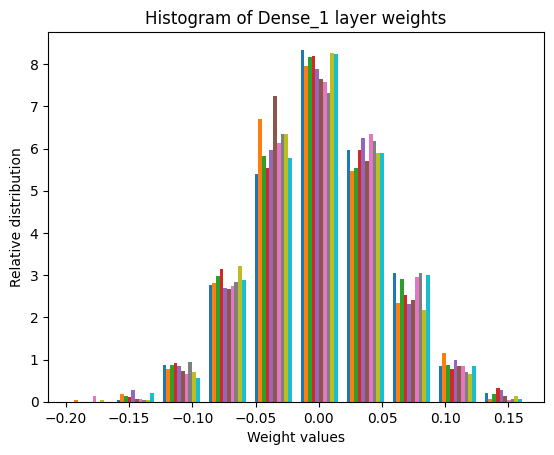

In [36]:
import utils
utils.plot_histogram(dense_1.layer_name, dense_1.weights)

In [40]:
28*28

784

In [41]:
dense_1.forward(np.random.randn(28,28,1))

array([0.13874263, 0.05280469, 0.07782047, 0.02119886, 0.07199721,
       0.11575452, 0.01926313, 0.10583565, 0.05895588, 0.33762698])